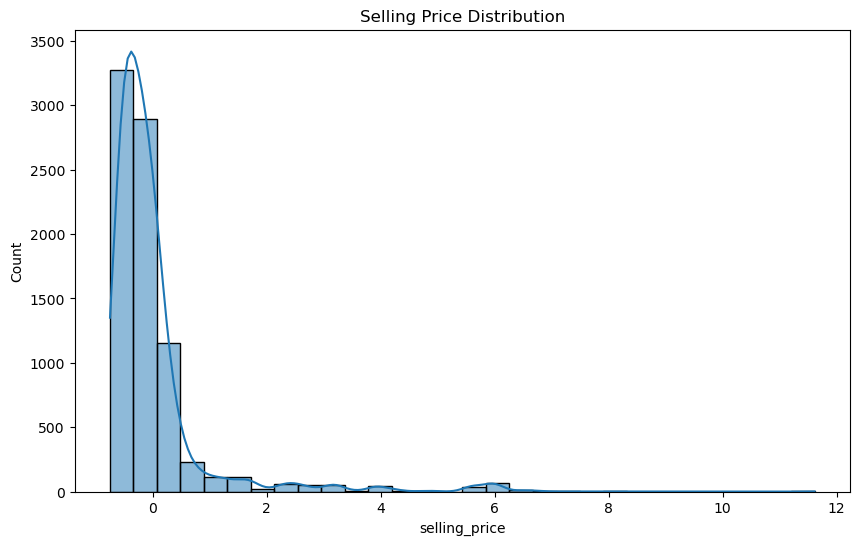

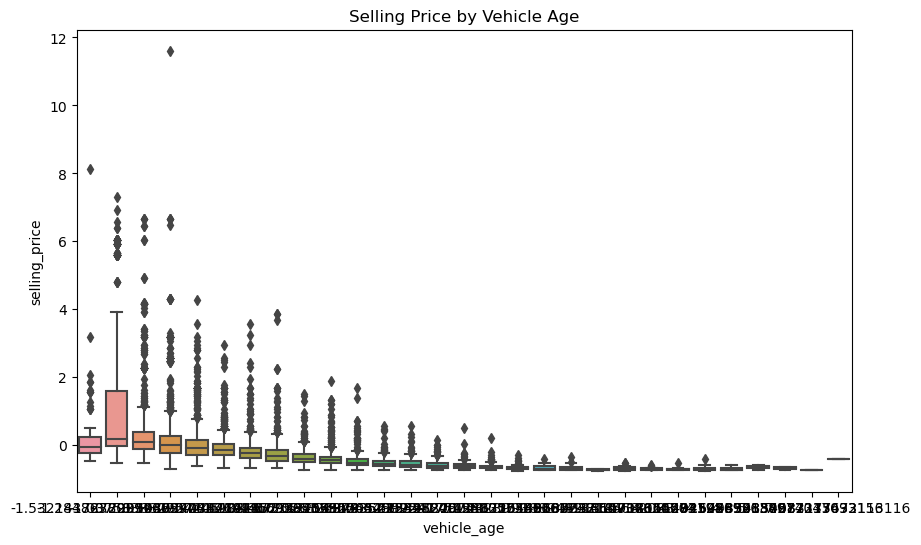

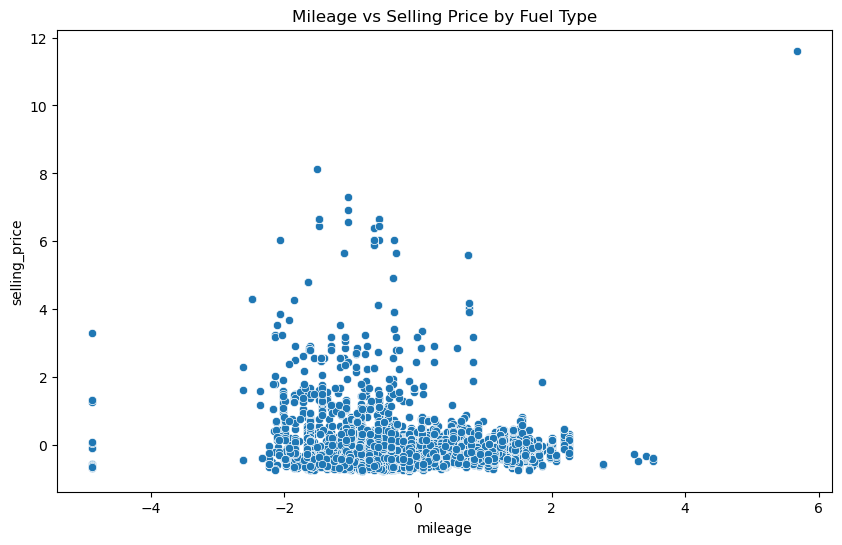

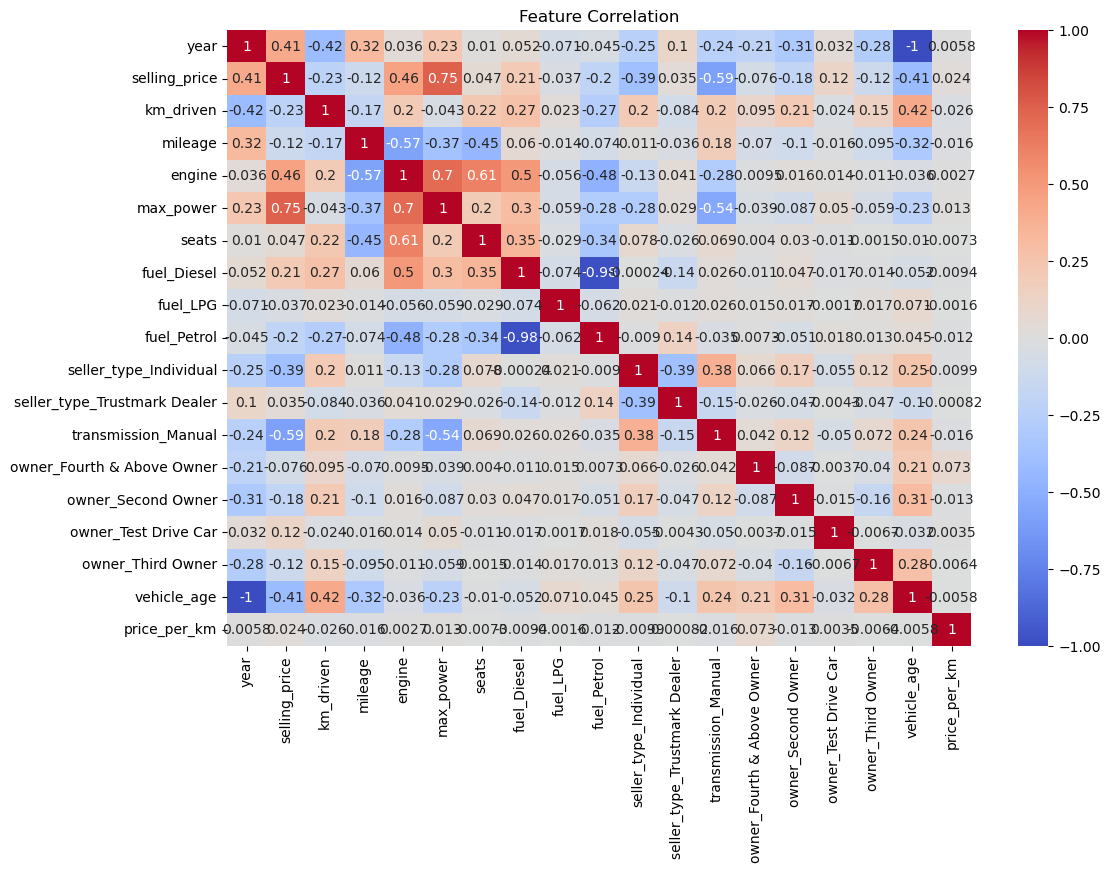

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('reg_cars_selling.csv')

# Step 1: Handle Missing Values
def handle_missing_values(df):
    df['mileage'] = df['mileage'].fillna(df['mileage'].mode()[0])
    df['engine'] = df['engine'].fillna(df['engine'].mode()[0])
    df['max_power'] = df['max_power'].fillna(df['max_power'].mode()[0])
    df['seats'] = df['seats'].fillna(df['seats'].median())
    return df

data = handle_missing_values(data)

# Step 2: Convert Units
def extract_numeric(value):
    if isinstance(value, str):
        return float(re.search(r"\d+\.?\d*", value).group()) if re.search(r"\d+\.?\d*", value) else np.nan
    return value

data['mileage'] = data['mileage'].apply(extract_numeric)
data['engine'] = data['engine'].apply(extract_numeric)
data['max_power'] = data['max_power'].apply(extract_numeric)

# Step 3: Encode Categorical Data
def encode_categorical(df, columns):
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cols = encoder.fit_transform(df[columns])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(columns))
    df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1).drop(columns, axis=1)
    return df

categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
data = encode_categorical(data, categorical_columns)

# Step 4: Feature Engineering
data['vehicle_age'] = 2025 - data['year']
data['price_per_km'] = data['selling_price'] / data['km_driven']

# Step 5: Outlier Detection
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]

outliers = detect_outliers(data, 'selling_price')

# Step 6: Normalize/Scale Data
scaler = StandardScaler()
scaled_columns = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'vehicle_age', 'price_per_km']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Step 7: Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(data['selling_price'], kde=True, bins=30)
plt.title("Selling Price Distribution")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='vehicle_age', y='selling_price', data=data)
plt.title("Selling Price by Vehicle Age")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mileage', y='selling_price', data=data)
plt.title("Mileage vs Selling Price by Fuel Type")
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

# Save Preprocessed Data
data.to_csv('preprocessed_reg_cars_selling.csv', index=False)


               Model      RMSE  R2 Score
0  Linear Regression  0.553754  0.695939
1      Random Forest  0.118456  0.986086
2      Decision Tree  0.153631  0.976596


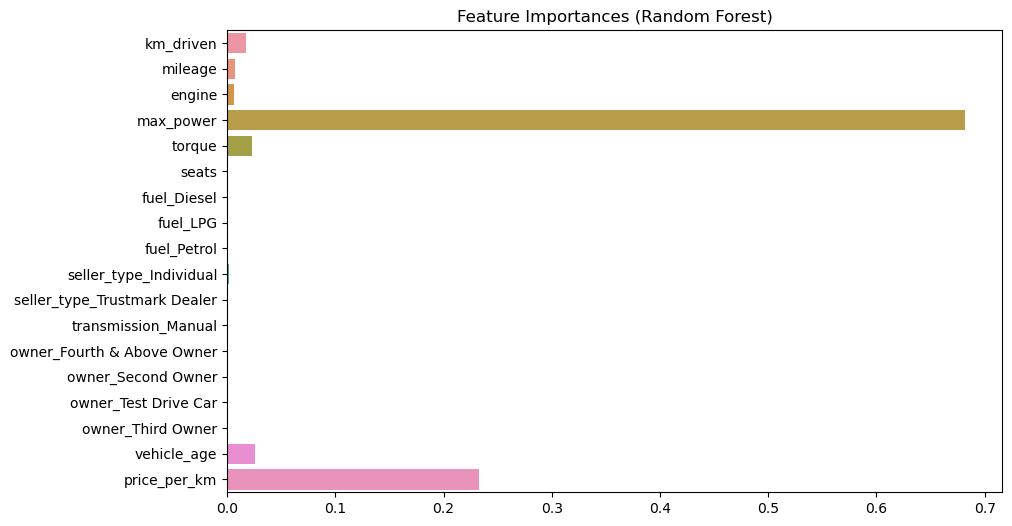

In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('reg_cars_selling.csv')

# Step 1: Handle Missing Values
def handle_missing_values(df):
    df['mileage'] = df['mileage'].fillna(df['mileage'].mode()[0])
    df['engine'] = df['engine'].fillna(df['engine'].mode()[0])
    df['max_power'] = df['max_power'].fillna(df['max_power'].mode()[0])
    df['seats'] = df['seats'].fillna(df['seats'].median())
    df['torque'] = df['torque'].fillna('0 Nm')
    return df

data = handle_missing_values(data)

# Step 2: Convert Units
def extract_numeric(value):
    if isinstance(value, str):
        return float(re.search(r"\d+\.?\d*", value).group()) if re.search(r"\d+\.?\d*", value) else np.nan
    return value

data['mileage'] = data['mileage'].apply(extract_numeric)
data['engine'] = data['engine'].apply(extract_numeric)
data['max_power'] = data['max_power'].apply(extract_numeric)
data['torque'] = data['torque'].apply(extract_numeric)

# Fill any remaining NaN values with median
numeric_columns = ['mileage', 'engine', 'max_power', 'torque']
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].median())

# Step 3: Encode Categorical Data
def encode_categorical(df, columns):
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cols = encoder.fit_transform(df[columns])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(columns))
    df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1).drop(columns, axis=1)
    return df

categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
data = encode_categorical(data, categorical_columns)

# Step 4: Feature Engineering
data['vehicle_age'] = 2025 - data['year']
data['price_per_km'] = data['selling_price'] / data['km_driven']

# Replace infinities or NaN in derived columns with 0
data['price_per_km'].replace([np.inf, -np.inf], 0, inplace=True)
data['price_per_km'].fillna(0, inplace=True)

# Step 5: Outlier Detection
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]

outliers = detect_outliers(data, 'selling_price')

# Step 6: Normalize/Scale Data
scaler = StandardScaler()
scaled_columns = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'vehicle_age', 'price_per_km', 'torque']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Save Preprocessed Data
data.to_csv('preprocessed_reg_cars_selling.csv', index=False)

# Machine Learning: Preparing Data for Training
X = data.drop(columns=['selling_price', 'name', 'year'])
y = data['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Algorithm 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
lr_r2 = r2_score(y_test, lr_pred)

# Algorithm 2: Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
rf_r2 = r2_score(y_test, rf_pred)

# Algorithm 3: Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)
dt_r2 = r2_score(y_test, dt_pred)

# Model Evaluation
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Decision Tree'],
    'RMSE': [lr_rmse, rf_rmse, dt_rmse],
    'R2 Score': [lr_r2, rf_r2, dt_r2]
})

print(results)

# Visualizing Feature Importances (for Random Forest)
plt.figure(figsize=(10, 6))
importances = rf.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances (Random Forest)")
plt.show()


In [6]:
import streamlit as st
st.title("Car Selling Price Prediction")
st.sidebar.header("Model Selection")
model_option = st.sidebar.selectbox("Choose the model to use:", ["Linear Regression", "Random Forest"])

st.sidebar.header("Input Features")
input_data = {}
for column in X.columns:
    input_data[column] = st.sidebar.number_input(f"{column.capitalize()}", value=float(X[column].mean()))

input_df = pd.DataFrame([input_data])

if model_option == "Linear Regression":
    prediction = lr.predict(input_df)[0]
    st.write(f"### Predicted Selling Price using Linear Regression: {prediction:.2f}")
    st.write(f"### Model Performance: RMSE = {lr_rmse:.2f}, R2 = {lr_r2:.2f}")

elif model_option == "Random Forest":
    prediction = rf.predict(input_df)[0]
    st.write(f"### Predicted Selling Price using Random Forest: {prediction:.2f}")
    st.write(f"### Model Performance: RMSE = {rf_rmse:.2f}, R2 = {rf_r2:.2f}")

st.write("## Feature Importance (Random Forest)")
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)
st.bar_chart(feature_importance_df.set_index("Feature"))


2025-01-11 16:16:52.332 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-11 16:16:52.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-11 16:16:52.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-11 16:16:52.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-11 16:16:52.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-11 16:16:52.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-11 16:16:52.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-11 16:16:52.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()